In [ ]:
getwd()
setwd('..')
getwd()

In [2]:
# 2000 cells -> 20min
# 5000 cells -> 40min
# 10000 cells -> 80min

In [3]:
library(SymSim)
library(SingleCellExperiment)
library(Seurat)

library(mclust)
library(scran)
library(Matrix)

Loading required package: plyr

Loading required package: ggplot2

Loading required package: Rtsne

Loading required package: grid

Loading required package: reshape


Attaching package: ‘reshape’


The following objects are masked from ‘package:plyr’:

    rename, round_any


Loading required package: RColorBrewer

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, inte

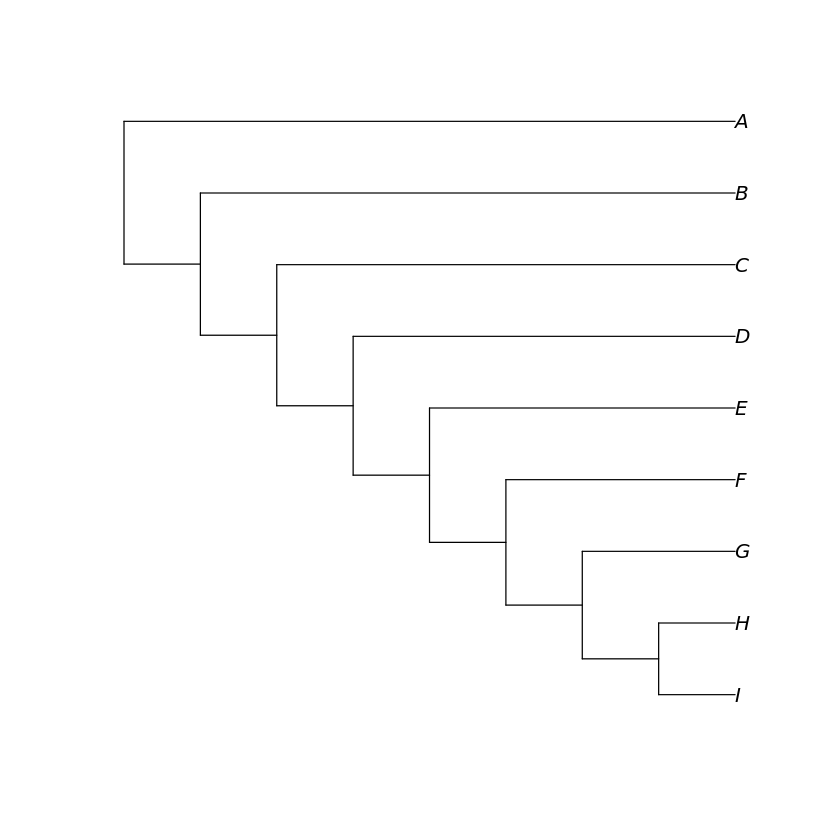

In [4]:
phyla_disc <- read.tree('experiments/tree_sameend.txt')
#par(mfrow=c(1,2))
plot(phyla_disc)

In [5]:
filter_exp <-function(sce,pct){
    expsn <- rowMeans(logcounts(sce))
    keep <- order(expsn, decreasing = TRUE)[seq_len(pct/100*length(expsn))]
    sce_filtered <- sce[keep, ]  
    
    sce_filtered
}

save_sce <- function(sce,path,lowdim='TSNE'){
    
    sizeFactors(sce) <- calculateSumFactors(sce)
    
    save_data <- Matrix(as.matrix(assay(sce,'counts')),sparse=TRUE)
    
    writeMM(save_data,sprintf("%s.data.counts.mm",path))
    write.table(as.matrix(rownames(save_data)),sprintf('%s.data.row',path),row.names=FALSE, col.names=FALSE)
    write.table(as.matrix(colnames(save_data)),sprintf('%s.data.col',path),row.names=FALSE, col.names=FALSE)
    
    tsne_data <- reducedDim(sce, lowdim)
    colnames(tsne_data) <- c(sprintf('%s_1',lowdim),sprintf('%s_2',lowdim))
    print(head(cbind(as.matrix(colData(sce)),tsne_data)))
    write.table(cbind(as.matrix(colData(sce)),tsne_data),sprintf('%s.metadatacol.tsv',path),row.names=TRUE, col.names=TRUE,sep='\t')    
    write.table(cbind(as.matrix(rowData(sce))),sprintf('%s.metadatarow.tsv',path),row.names=TRUE, col.names=TRUE,sep='\t')    
    
    write.table(sizeFactors(sce),file=sprintf('%s.size_factor.tsv',path),sep='\t',row.names=FALSE, col.names=FALSE)    
    
}

save_hvg_seurat <-function(sce,path,method){
    seurat <- CreateSeuratObject(counts = counts(sce), project = "scRNAseq", assay = "RNA",
                                         min.cells = 0, min.features = 0,
                                         meta.data = as.data.frame(colData(sce)))
    #seurat <- ScaleData(seurat, vars.to.regress = "nUMI", display.progress = FALSE)
    seurat <- NormalizeData(seurat)
    seurat <- FindVariableFeatures(seurat, selection.method = method, nfeatures = length(rownames(seurat@assays$RNA)))
    vf <- VariableFeatures(seurat)  
    write.table(vf,file=sprintf('%s.hvg.%s.tsv',path,method),sep='\t',row.names=FALSE, col.names=TRUE)       
}

In [6]:
ncells_total=10000

In [7]:
for(i in c(1:5)){
    #############
    #True counts
    #############
    disc_true_counts <- SimulateTrueCounts(ncells_total=ncells_total, 
                                          min_popsize=50, 
                                          i_minpop=1, 
                                          ngenes=5000, 
                                          nevf=20, 
                                          evf_type="discrete", 
                                          n_de_evf=5,
                                          vary="s",
                                          geffect_mean=1,
                                          Sigma=0.4,
                                          bimod = 1,
                                          phyla=phyla_disc,
                                          gene_effect_prob=0.01,
                                          randseed=i)
    
    if(FALSE){
        disc_true_counts_tsne <- PlotTsne(meta=disc_true_counts[[3]][,c('cellid','pop')],
                                     data=log2(disc_true_counts[[1]]+1),
                                     evf_type="discrete",
                                     n_pc=30,
                                     label='pop',
                                     saving = F,
                                     plotname="discrete populations (true counts)")
        disc_true_counts_tsne[[2]]        
    }
    
    
    #############
    #Observed counts
    #############    
    
    gene_len <- sample(gene_len_pool, 5000, replace = FALSE)
    
    
    disc_observed_UMI <- True2ObservedCounts(true_counts=disc_true_counts[[1]],
                                             meta_cell=disc_true_counts[[3]],
                                             protocol="UMI",
                                             alpha_mean=0.05,
                                             alpha_sd=0.02,
                                             gene_len=gene_len,
                                             depth_mean=5e5,
                                             depth_sd=3e4)   
    
    if(FALSE){
        disc_observed_UMI_tsne <- PlotTsne(meta=disc_observed_UMI[[2]],
                                           data=log2(disc_observed_UMI[[1]]+1),
                                           evf_type="discrete",
                                           n_pc=20,
                                           label='pop',
                                           saving = F,
                                           plotname="observed counts UMI")
        disc_observed_UMI_tsne[[2]]           
    }
    
    #############
    #Saving
    #############    
    
    
    count=disc_observed_UMI[[1]]
    colnames(count)=c(disc_observed_UMI[[2]]['cellid'])$cellid
    rownames(count)=c(1:dim(count)[1])
 
    seurat <- CreateSeuratObject(counts = count)
    seurat@meta.data$phenoid=c(disc_observed_UMI[[2]]['pop'])$pop    
    
    seurat=FindVariableFeatures(seurat, selection.method = "vst", nfeatures = 2000)

    seurat_hvg <- NormalizeData(seurat)

    all.genes <- rownames(seurat_hvg)
    seurat_hvg=ScaleData(seurat_hvg,features = all.genes)

    seurat_hvg_pca = RunPCA(seurat_hvg)

    PC_cluster=50
    PC_2D=50

    seurat_hvg_pca <- RunTSNE(seurat_hvg_pca, dims= 1:PC_2D)

    seurat_hvg_pca_label <- FindNeighbors(seurat_hvg_pca, dims = 1:PC_cluster)

    seurat_hvg_pca_label_cluster <- FindClusters(seurat_hvg_pca_label, resolution = 2)

    DimPlot(seurat_hvg_pca_label_cluster,group.by='phenoid',cols = DiscretePalette(22))

    DimPlot(seurat_hvg_pca_label_cluster,group.by='seurat_clusters',cols = DiscretePalette(22))

    print(adjustedRandIndex(seurat@meta.data$phenoid, seurat_hvg_pca_label_cluster@meta.data$seurat_clusters))

    
    sce_full_Simul <- as.SingleCellExperiment(seurat_hvg_pca_label_cluster)
    
    sce_full_Simul_expfiltered=filter_exp(sce_full_Simul,30)
    
    
    path=sprintf('datasets/extract/Simul_%s_1e-2_%s_filtered',ncells_total,i)
    
    save_sce(sce_full_Simul_expfiltered, path)
    saveRDS(disc_true_counts, file = sprintf('datasets/extract/Simul_%s_1e-2_%s_filtered.true_counts.rds',ncells_total,i))
    
    for(method in c('vst','mvp','disp')){
        save_hvg_seurat(sce_full_Simul_expfiltered, path, method)
    }    
    
    
}

Centering and scaling data matrix

PC_ 1 
Positive:  4735, 2910, 4816, 3989, 3252, 4503, 3098, 4824, 4765, 1280 
	   3295, 4686, 3085, 2958, 4224, 4495, 1520, 473, 2271, 1622 
	   814, 1334, 1744, 2064, 2805, 3107, 2523, 3125, 2300, 1472 
Negative:  2039, 3090, 942, 132, 2586, 3778, 4741, 3018, 3944, 3816 
	   4092, 2575, 2932, 4934, 2842, 3157, 4135, 4205, 4463, 392 
	   2744, 4995, 125, 3531, 4679, 2686, 3726, 4276, 3541, 2720 
PC_ 2 
Positive:  2586, 2910, 4503, 3252, 1280, 4735, 4205, 3090, 132, 4135 
	   3810, 4686, 2932, 3098, 4224, 3157, 4495, 3085, 3295, 3989 
	   4435, 4824, 3778, 4765, 4816, 3281, 3018, 3711, 4741, 353 
Negative:  1982, 96, 1879, 3573, 3660, 3125, 3107, 4217, 678, 4337 
	   942, 3524, 4636, 1171, 4443, 3944, 2805, 3706, 3365, 2983 
	   4725, 3491, 4998, 4884, 2101, 36, 2744, 3228, 4463, 2897 
PC_ 3 
Positive:  4636, 678, 1171, 3228, 4509, 3213, 3188, 3095, 3880, 4371 
	   2910, 964, 65, 1848, 2230, 3932, 2972, 2843, 1926, 110 
	   1280, 4135, 1271, 4100, 1823

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10000
Number of edges: 504449

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7235
Number of communities: 36
Elapsed time: 1 seconds


1 singletons identified. 35 final clusters.



[1] 0.4008078
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      28042         2702       1            31               6
cell_2          1      18347         2305       1            23              30
cell_3          1      13785         1640       1             8              16
cell_4          1      19139         2510       1            31               6
cell_5          1      34333         2815       1            31               6
cell_6          1       3157          841       1            34               9
       ident sizeFactor    TSNE_1      TSNE_2
cell_1     6  1.0210994 16.113389   7.3587563
cell_2    30  0.6566778 -9.434790   2.5575138
cell_3    16  0.3744907 -5.166711   2.4194810
cell_4     6  0.8602096 11.841510   8.2351556
cell_5     6  1.2378606  9.923945  -0.4352574
cell_6     9  0.1213095 17.584796 -10.1662801


Centering and scaling data matrix

PC_ 1 
Positive:  4276, 4960, 4612, 4432, 2909, 4177, 3136, 3724, 4096, 4188 
	   2989, 1418, 1075, 1947, 3828, 840, 2963, 1339, 2725, 53 
	   1443, 1956, 61, 2648, 4258, 3208, 721, 2024, 1373, 209 
Negative:  1246, 3493, 4910, 2749, 2515, 1570, 3260, 4614, 4541, 4926 
	   2848, 3414, 2750, 3922, 3768, 4256, 4352, 4706, 3674, 3247 
	   116, 3932, 2355, 1430, 4687, 3286, 3925, 104, 3502, 2499 
PC_ 2 
Positive:  2648, 721, 1373, 2718, 1463, 4910, 1570, 2494, 3414, 1246 
	   2515, 770, 1008, 2749, 1430, 1055, 3493, 116, 717, 2355 
	   2499, 3630, 173, 1480, 3674, 1208, 3260, 2179, 2848, 3932 
Negative:  4276, 4612, 4960, 4177, 4096, 3724, 2909, 4432, 3136, 4188 
	   3828, 2963, 2989, 2725, 1075, 1947, 840, 1339, 53, 1418 
	   3704, 2528, 3538, 4461, 1792, 185, 3789, 3209, 2772, 2983 
PC_ 3 
Positive:  2304, 1792, 3538, 3884, 4100, 4138, 2774, 3047, 3012, 4461 
	   2823, 4177, 4498, 3826, 4352, 3674, 3286, 3925, 4612, 2790 
	   1457, 1329, 290, 104, 3932,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10000
Number of edges: 363318

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6608
Number of communities: 34
Elapsed time: 1 seconds
[1] 0.3138898
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      32418         2935       1             2               2
cell_2          1      30023         2916       1            12              12
cell_3          1      29459         2865       1             2               2
cell_4          1      25327         2694       1             3               3
cell_5          1      31325         2749       1             3               3
cell_6          1       7589         1456       1             3               3
       ident sizeFactor     TSNE_1     TSNE_2
cell_1     2  1.4276675   1.941197  -9.023638
cell_2    12  1.3011523 -16.015577 -11.684590
cell_3     2  1.3672556  -3.465208  -8.37

Centering and scaling data matrix

PC_ 1 
Positive:  3515, 3451, 3846, 3655, 4944, 2628, 2769, 525, 4514, 3785 
	   3803, 3676, 4975, 1793, 4985, 4270, 1596, 3007, 3343, 4807 
	   3009, 3521, 3313, 3392, 1574, 759, 1636, 3142, 3052, 4315 
Negative:  3948, 4283, 4321, 3498, 2187, 4813, 1963, 4940, 3306, 3568 
	   2437, 4076, 4153, 4693, 1774, 2993, 2773, 2140, 2559, 1154 
	   2382, 1017, 4035, 529, 2327, 4265, 1151, 3181, 1835, 1450 
PC_ 2 
Positive:  3846, 1793, 4975, 4514, 3451, 4985, 3676, 4807, 4944, 427 
	   4270, 3803, 2769, 3343, 525, 3165, 1191, 508, 3515, 4315 
	   3785, 3655, 4559, 4859, 2859, 2277, 4066, 2529, 759, 1702 
Negative:  3392, 1596, 3007, 3009, 3521, 3313, 3142, 3052, 3014, 4216 
	   506, 4561, 3878, 4624, 3836, 1085, 728, 854, 667, 2628 
	   1461, 1783, 1328, 1281, 4891, 3948, 4321, 4283, 3498, 4813 
PC_ 3 
Positive:  4321, 4283, 3948, 3498, 4153, 4813, 4076, 4940, 4693, 2773 
	   1963, 2437, 1774, 3568, 3306, 3846, 2382, 2993, 529, 1017 
	   1194, 1156, 1450, 656

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10000
Number of edges: 450782

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6768
Number of communities: 26
Elapsed time: 1 seconds


1 singletons identified. 25 final clusters.



[1] 0.5079626
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      43622         2693       1             1               1
cell_2          1      29914         2083       1            20               5
cell_3          1      29006         2277       1            24               9
cell_4          1      37589         2332       1            20               5
cell_5          1      36300         2511       1             1               1
cell_6          1      62642         2903       1            20               5
       ident sizeFactor     TSNE_1      TSNE_2
cell_1     1  1.1209902  3.0770002   2.5205528
cell_2     5  0.6202339 -3.3947945   9.7500518
cell_3     9  0.7173706 15.6243213 -28.5199254
cell_4     5  0.8093905 -0.4789678   9.8259165
cell_5     1  0.9405244  2.5712045   0.8098929
cell_6     5  1.4150817 -2.0598860  10.7804525


Centering and scaling data matrix

PC_ 1 
Positive:  3196, 3588, 2875, 2560, 829, 1278, 2471, 4286, 4246, 4801 
	   3092, 3583, 3752, 3795, 2628, 4290, 3198, 3341, 4909, 3981 
	   3727, 2741, 3849, 2946, 1631, 4427, 4005, 3430, 48, 2656 
Negative:  3130, 4910, 2345, 2736, 936, 3024, 4323, 3742, 4979, 4213 
	   4382, 4651, 4857, 4571, 1911, 2895, 402, 4734, 116, 2613 
	   3767, 2304, 2221, 3560, 2097, 1688, 456, 281, 1904, 1163 
PC_ 2 
Positive:  1081, 2550, 3906, 3044, 3225, 52, 4859, 3554, 4715, 4559 
	   3089, 2593, 4649, 993, 3397, 3450, 972, 2115, 558, 1566 
	   1564, 2255, 1254, 1908, 1981, 4267, 2414, 1493, 2741, 1631 
Negative:  4470, 2621, 594, 1278, 2628, 2875, 3092, 2560, 4801, 3583 
	   936, 939, 490, 3742, 4323, 2471, 4213, 4382, 4979, 3024 
	   3752, 3795, 3849, 4005, 84, 4857, 2895, 4734, 969, 2141 
PC_ 3 
Positive:  3588, 4909, 3198, 3727, 4286, 2946, 3430, 4290, 2974, 2621 
	   4437, 4470, 829, 594, 4246, 4440, 4427, 936, 3341, 3981 
	   3196, 3024, 4728, 4213, 4857, 28

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10000
Number of edges: 500600

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7190
Number of communities: 27
Elapsed time: 1 seconds
[1] 0.4681857
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      29222         2850       1             1               1
cell_2          1      24159         2815       1             3               3
cell_3          1      21685         2551       1             3               3
cell_4          1      29752         2670       1             7               7
cell_5          1      19175         2393       1             1               1
cell_6          1      24876         2273       1            21              21
       ident sizeFactor      TSNE_1     TSNE_2
cell_1     1  1.2820358  16.1580772 -0.4609999
cell_2     3  1.2476860  -0.6460463 12.7013692
cell_3     3  0.9065363  -1.6567045 13

Centering and scaling data matrix

PC_ 1 
Positive:  2760, 4210, 1917, 4473, 513, 4951, 4363, 4236, 2526, 2543 
	   2046, 2621, 3754, 154, 4910, 3118, 2979, 4277, 4758, 2910 
	   3834, 3576, 1186, 2619, 2776, 2658, 3374, 988, 652, 2029 
Negative:  3966, 4580, 2871, 773, 3044, 4187, 2712, 3915, 3099, 4790 
	   4081, 2738, 4320, 1354, 2567, 2274, 2669, 4443, 4327, 1972 
	   4898, 2014, 3708, 68, 3534, 1220, 4403, 3369, 455, 3520 
PC_ 2 
Positive:  2567, 4320, 2669, 4327, 4898, 3534, 3369, 3708, 3520, 4403 
	   4457, 3775, 622, 4750, 2214, 3756, 2615, 973, 2234, 3776 
	   235, 521, 3014, 4226, 2299, 2116, 1426, 187, 445, 979 
Negative:  4324, 4592, 4527, 2624, 4159, 3051, 4147, 2912, 3404, 3557 
	   3313, 4187, 3044, 3980, 773, 4580, 2712, 1354, 2496, 3915 
	   3099, 133, 4790, 4081, 2383, 1969, 2738, 4917, 375, 4362 
PC_ 3 
Positive:  3708, 4457, 4403, 3775, 3756, 3369, 2669, 4898, 4327, 3520 
	   3534, 4750, 4320, 2615, 3776, 3014, 2567, 4226, 2787, 2751 
	   4860, 3412, 4449, 3157, 463

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10000
Number of edges: 502744

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7130
Number of communities: 31
Elapsed time: 1 seconds
[1] 0.4157305
       orig.ident nCount_RNA nFeature_RNA phenoid RNA_snn_res.2 seurat_clusters
cell_1          1      30920         2546       1             6               6
cell_2          1      24139         2418       1             6               6
cell_3          1       5045         1336       1             1               1
cell_4          1      24319         2611       1             1               1
cell_5          1      24960         2492       1             6               6
cell_6          1      21902         2071       1             6               6
       ident sizeFactor     TSNE_1     TSNE_2
cell_1     6  0.9211459 -10.272880  -8.236174
cell_2     6  0.8388137  -4.199527 -10.086443
cell_3     1  0.2366294 -11.269632 -16.59

In [5]:
#help(SimulateTrueCounts)
#0.01, 0.005, 0.001, 0.0005 0.0001

In [ ]:
'datasets/extract/Kohinbulk_filtered'

In [12]:
#saveRDS(disc_observed_UMI, file = "datasets/simul/disc_observed_UMI12.rds")

In [13]:
#saveRDS(disc_true_counts, file = "datasets/simul/disc_true_counts12.rds")

In [14]:
'datasets/extract/Kohinbulk_filtered'

[1] "datasets/extract/Simul_1_1e-2_5_filtered"

Warning message:
“'normalizeSCE' is deprecated.
Use 'logNormCounts' instead.
See help("Deprecated")”
Warning message:
“'centreSizeFactors' is deprecated.
See help("Deprecated")”


       orig.ident phenoid    tSNE_1     tSNE_2
cell_1          1       1  1.290648 -0.5960434
cell_2          1       1  2.295489 -9.3229477
cell_3          1       1  2.285761 -0.4733488
cell_4          1       1 -3.107209  2.2224019
cell_5          1       1 -2.828975  1.0804327
cell_6          1       1  1.526465 -0.4216981


In [40]:
sce_full_simul=SingleCellExperiment(assays = list(counts = count))

In [41]:
colData(sce_full_simul)$phenoid=c(disc_observed_UMI[[2]]['pop'])$pop

class: SingleCellExperiment 
dim: 500 1000 
metadata(0):
assays(1): counts
rownames(500): 1 2 ... 499 500
rowData names(0):
colnames(1000): cell_1 cell_2 ... cell_999 cell_1000
colData names(0):
reducedDimNames(0):
spikeNames(0):
altExpNames(0):

In [ ]:
sce_full_HumanLiver <- SingleCellExperiment(assays = list(counts = HumanLiverSeurat[['RNA']]@counts))